In [2]:
import requests

HOST      = '172.20.10.2'
PORT 	  = '8005'
autologin = 1

# BASE_URL is variant use to save the format of host and port 
BASE_URL = 'http://' + HOST + ':'+ PORT + '/'

def __request__(url, times=10):
	for x in range(times):
		try:
			requests.get(url)
			return 0
		except :
			print("Connection error, try again")
	print("Abort")
	return -1

def run_action(cmd):
	"""Ask server to do sth, use in running mode

	Post requests to server, server will do what client want to do according to the url.
	This function for running mode

	Args:
		# ============== Back wheels =============
		'bwready' | 'forward' | 'backward' | 'stop'

		# ============== Front wheels =============
		'fwready' | 'fwleft' | 'fwright' |  'fwstraight'

		# ================ Camera =================
		'camready' | 'camleft' | 'camright' | 'camup' | 'camdown'
	"""
	# set the url include action information
	url = BASE_URL + 'run/?action=' + cmd
	print('url: %s'% url)
	# post request with url 
	__request__(url)

def run_speed(speed):
	"""Ask server to set speed, use in running mode

	Post requests to server, server will set speed according to the url.
	This function for running mode.

	Args:
		'0'~'100'
	"""
	# Set set-speed url
	url = BASE_URL + 'run/?speed=' + speed
	print('url: %s'% url)
	# Set speed
	__request__(url)
    
    
def run_fwturn(angle):
    
	url = BASE_URL + 'run/?action=fwturn:' + str(angle)
	print('url: %s'% url)
	__request__(url)


def connection_ok():
	"""Check whetcher connection is ok

	Post a request to server, if connection ok, server will return http response 'ok' 

	Args:
		none

	Returns:
		if connection ok, return True
		if connection not ok, return False
	
	Raises:
		none
	"""
	cmd = 'connection_test'
	url = BASE_URL + cmd
	print('url: %s'% url)
	# if server find there is 'connection_test' in request url, server will response 'Ok'
	try:
		r=requests.get(url)
		if r.text == 'OK':
			return True
	except:
		return False

print(f'Connection Ok: {connection_ok()}')
run_action('fwready')
run_action('bwready')
run_action('camready')

url: http://172.20.10.2:8005/connection_test
Connection Ok: True
url: http://172.20.10.2:8005/run/?action=fwready
url: http://172.20.10.2:8005/run/?action=bwready
url: http://172.20.10.2:8005/run/?action=camready


slope: 174.66049140434885
intercept: 17.0882722348693


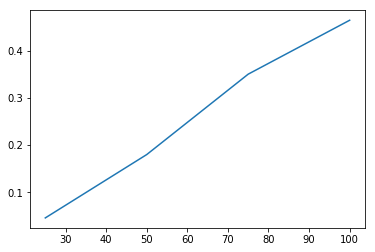

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import pickle

# PHYSICAL SPEED - DIGITAL SPEED CALIBRATION
# run_speed('100')

# run_action('forward')
# time.sleep(5)
# run_action('stop')        

# print('This moved 2.32 meters')
# print('Finished')

# run_speed('50')

# run_action('forward')
# time.sleep(5)
# run_action('stop')        

# print('This moved 90 cm')
# print('Finished')

# run_speed('75')

# run_action('forward')
# time.sleep(5)
# run_action('stop')        

# print('This moved 1.75 meters')
# print('Finished')

# run_speed('25')

# run_action('forward')
# time.sleep(5)
# run_action('stop')        

# print('This moved 23 cm')
# print('Finished')

dig_speeds = np.array([25, 50, 75, 100])
dis_moved = np.array([0.23, 0.9, 1.75, 2.32])

phy_speeds = dis_moved / 5.0  # meter per second

plt.plot(dig_speeds, phy_speeds)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(phy_speeds, dig_speeds)

print(f'slope: {slope}')
print(f'intercept: {intercept}')

def phy_to_dig_speed(phy_speed):
    return phy_speed * slope + intercept

# for v in phy_speeds:
#     print(phy_to_dig_speed(v))

# PHYSICAL STEERING ANGLE TO DIGITAL STEERING ANGLE CALIBRATION

def phy_to_dig_steering_angle(angle):
    
    dis_from_straight_line = 7.0 * np.tan(angle)  

    # 7 is the distance between the intersection of the 2 lines coming from the two wheels positions
    # at the 2 extreme left and right steering position

    if angle < 0:  # turn left
        return 90 - dis_from_straight_line  # 90 is the angle to input into the car to put front wheel into forward heading
    elif angle > 0:
        return 90 + dis_from_straight_line
    else:
        return 90     

In [4]:
import time

class BicycleKinematicModel(object):
    def __init__(self, L):
        self.theta = 0
        self.L = L  # wheel base
        
    def forward(self, v, gamma):
        # Implement kinematic model
        
        # enforce physical constraint
        v = np.clip(v, -100, 100)
        gamma = np.clip(gamma, -np.radians(90), np.radians(90))
        
        x = v * np.cos(self.theta)
        y = v * np.sin(self.theta)
        theta = next_theta = v * np.tan(gamma) / self.L
                
        return x, y, next_theta
    
    
def to_polar(x, y, theta, direction):
    
    rho = np.sqrt(x ** 2 + y ** 2)
    
    if direction == 0: # First time in simulation, the direction is not set 
        beta = - np.arctan2(-y, -x)
        alpha = - theta - beta
        print('beta', beta)
        print('alpha', alpha)
        if (alpha > np.pi/2.0 or alpha < -np.pi/2):
            # need to go backward
            direction = -1
        else:
            direction = 1
    elif direction == -1:
        beta = - np.arctan2(y, x)
        alpha = - theta - beta
    else:
        beta = - np.arctan2(-y, -x)
        alpha = - theta - beta
    
    # Set limit on alpha
    if alpha > np.pi/2.0:
        alpha = np.pi/2.0
    
    if alpha < - np.pi/2.0:
        alpha = - np.pi/2.0
        
    return rho, alpha, beta, direction


def we_are_there(rho):
    return np.abs(rho) < 0.08


def drive_pose(rho, alpha, beta, direction, ki_model, consts={}):
    
    kalpha = consts['kalpha']
    kbeta = consts['kbeta']
    krho = consts['krho']
    
    z1 = kalpha * alpha + kbeta * beta
    
    v = rho * krho * direction 
    
    z2 = z1 * direction / np.abs(v)
        
    gamma = np.arctan(z2)
    
    print(v, z2, gamma)

    x, y, theta = ki_model.forward(v, gamma)
    
    # change of coordinate for x, y
    x_star, y_star = consts['x_star'], consts['y_star']
    
    x -= x_star
    y -= y_star
    
    rho, alpha, beta, direction = to_polar(x, y, theta, direction)
    
    there_yet = we_are_there(rho)
    
    # beta change of coordinate
    beta = beta + consts['target_heading']
    
    return rho, alpha, beta, direction, v, gamma, there_yet

def test(target):

    ki_model = BicycleKinematicModel(15)  # the wheel base of the car is 15cm
    
    consts = {
        'kalpha': 5,
        'kbeta': -2,
        'krho': 1,
        'x_star': target[0], 
        'y_star': target[1],
        'target_heading': target[2]
    }

    rho, alpha, beta, direction = to_polar(target[0], target[1], 0.0, 0.0)
        
    start_t = time.time()
    
    return
    
    while True:
        rho, alpha, beta, direction, v, gamma, there_yet = drive_pose(rho, alpha, beta, direction, ki_model, consts)
        
        dig_angle = int(phy_to_dig_steering_angle(gamma))
        
        run_fwturn(dig_angle)
        
        print(f'angle: {dig_angle}')
        
        dig_speed = int(phy_to_dig_speed(int(np.abs(v))))
        
        print(f'speed: {dig_speed}')
        run_speed(str(dig_speed))
        
        if direction == 1:
            run_action('forward')
        elif direction == -1:
            run_action('backward')
        else:
            assert False, 'unrecognized directionn'

        time.sleep(1.0)

        if there_yet:
            print('We are there')
            break
            
        if time.time() - start_t > 4:
            run_action('stop')
            break
            
test([1, 1, 0])
# test([1, 1, 0])

beta 2.356194490192345
alpha -2.356194490192345


In [ ]:
run_action('stop')
# test([1, 1, 0])